In [106]:
# Postprocessing and grain size analysis
# Author: Chengchao Xu
# Date: 2025-03-11

# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread, imsave
from skimage import feature, morphology, util, segmentation
from scipy import ndimage as ndi
from skimage.morphology import disk, erosion, dilation, closing, opening
from skimage.measure import label, regionprops
from skimage.segmentation import watershed
from skimage.feature import multiscale_basic_features, peak_local_max
import BSSEM_utils
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

# read the image and predictions
image_dir = os.path.join('..', 'image_files', 'AG56-A')  # Use os.path.join for proper path separators
image_filename = 'AG56-D2-A-50K-002'

# Create input path
test_filepath = os.path.join(image_dir, image_filename +'_test.tif')
pred_filepath = os.path.join(image_dir, image_filename +'_predict_GBs.tif')
test_image = imread(test_filepath)
prediction = imread(pred_filepath)


In [107]:
def plot_image(image, title=None, cmap='gray'):
    """
    Visualize an image.
    
    Args:
        image (ndarray): Input image
        title (str): Title for the plot
        cmap (str): Colormap
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    
    if title is not None:
        plt.title(title)
    plt.show()

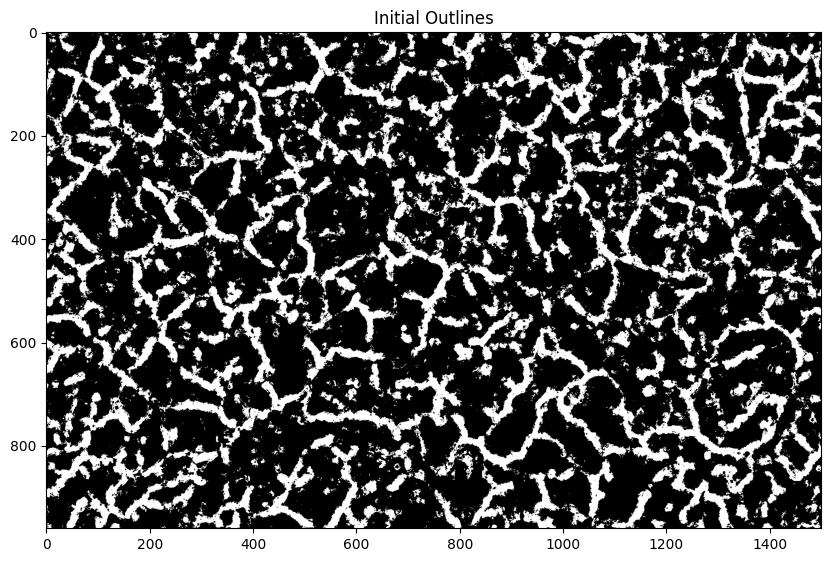

[0 1]
(960, 1500)


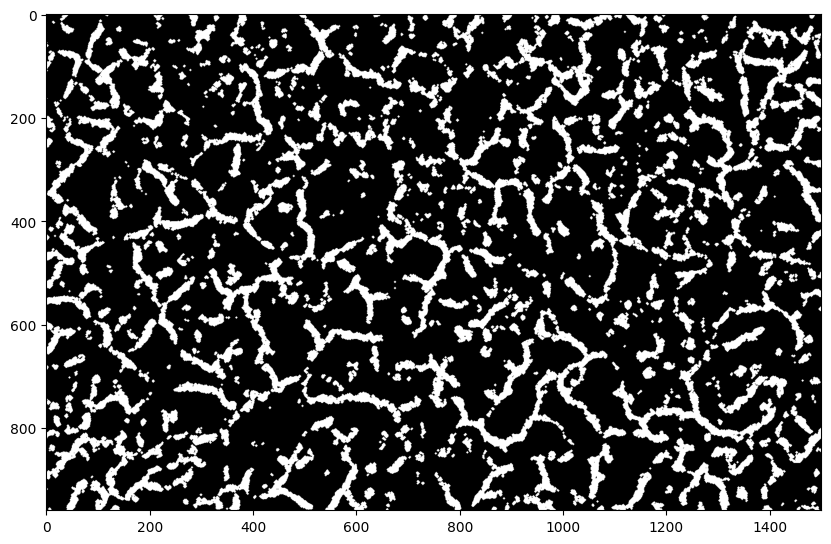

In [108]:
# Step 1: Extract outlines (inverting prediction to get outlines)
outlines = prediction
plot_image(outlines, title="Initial Outlines")
print(np.unique(outlines))
print(outlines.shape)
# step2: apply opening to remove salts
outline_cleaned = BSSEM_utils.apply_opening(outlines, 2)
plot_image(outline_cleaned)



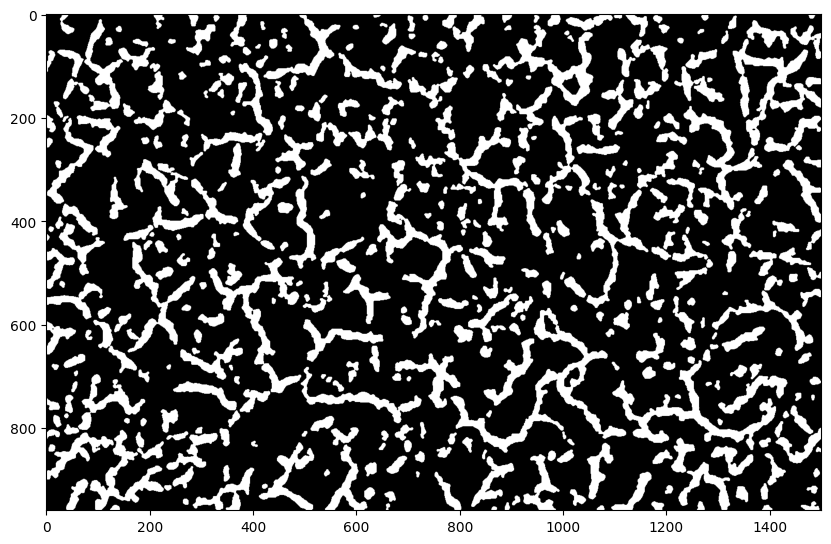

In [109]:
#step 3 OPTIONAL: connection boundary dots
outline_connected = BSSEM_utils.connect_boundary_dots(outline_cleaned, line_length=3, min_size=50)
plot_image(outline_connected)

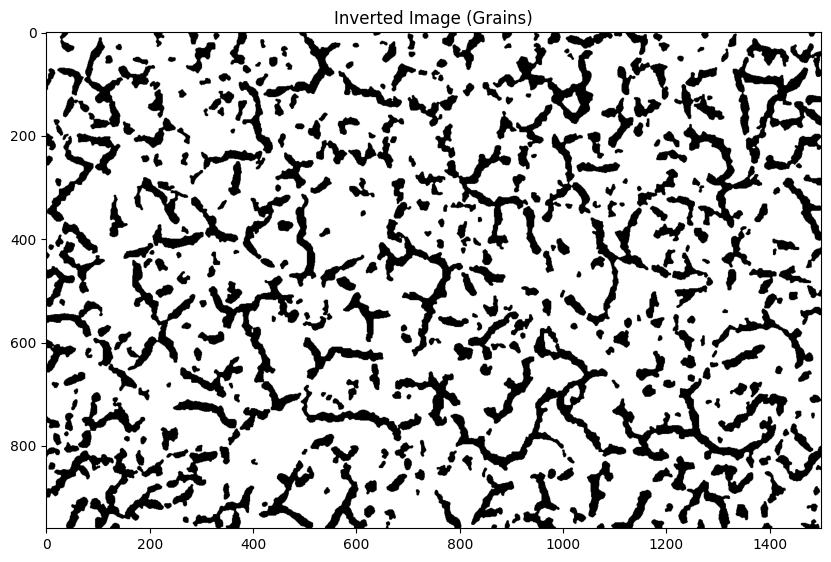

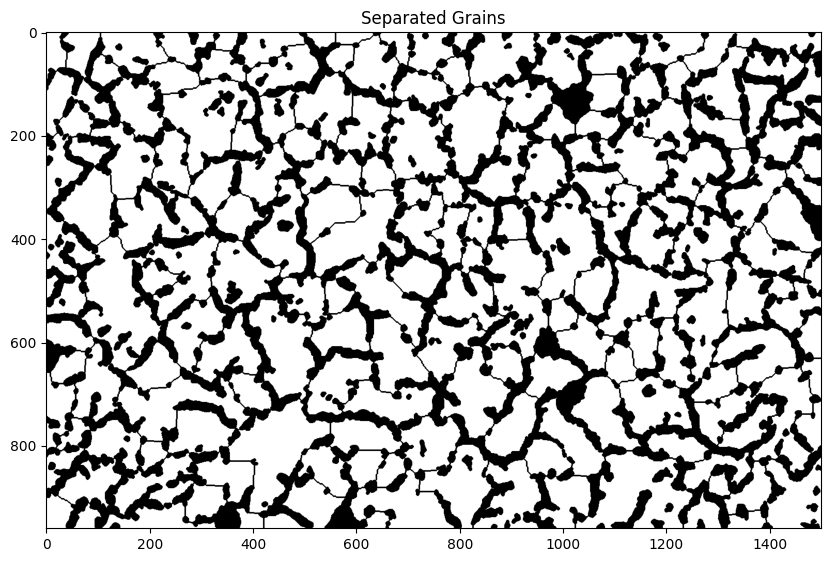

In [110]:

# step4 invert back to grains
inverted = 1- outline_connected
plot_image(inverted, title="Inverted Image (Grains)")

# Step 5: Separate touching grains
separated, watershed_labels, distance_map = BSSEM_utils.separate_touching(
    inverted, min_distance=40, num_erosions=1
)
plot_image(separated, title="Separated Grains")

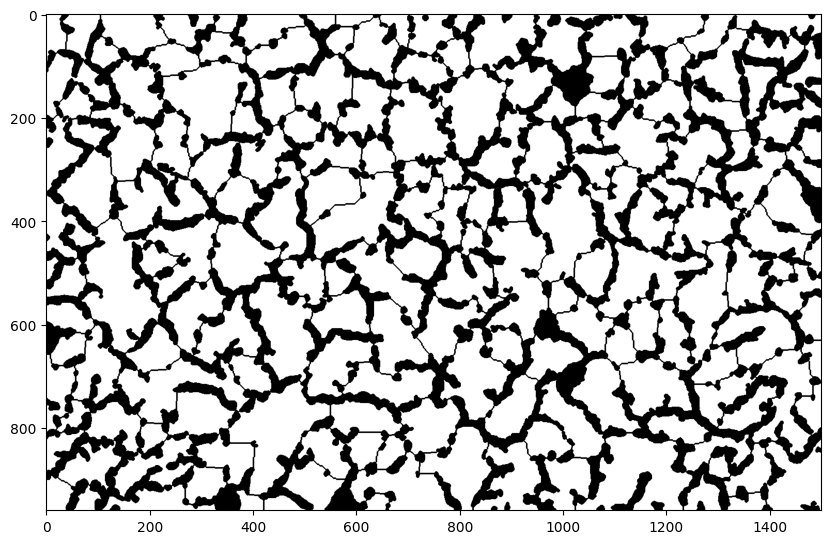

In [111]:
# step6: fill holes in the grains
grain_cleaned = BSSEM_utils.fill_grain_holes(separated, max_hole_size=2000)
grain_cleaned = BSSEM_utils.remove_small_objects(grain_cleaned, min_size = 40)
plot_image(grain_cleaned)

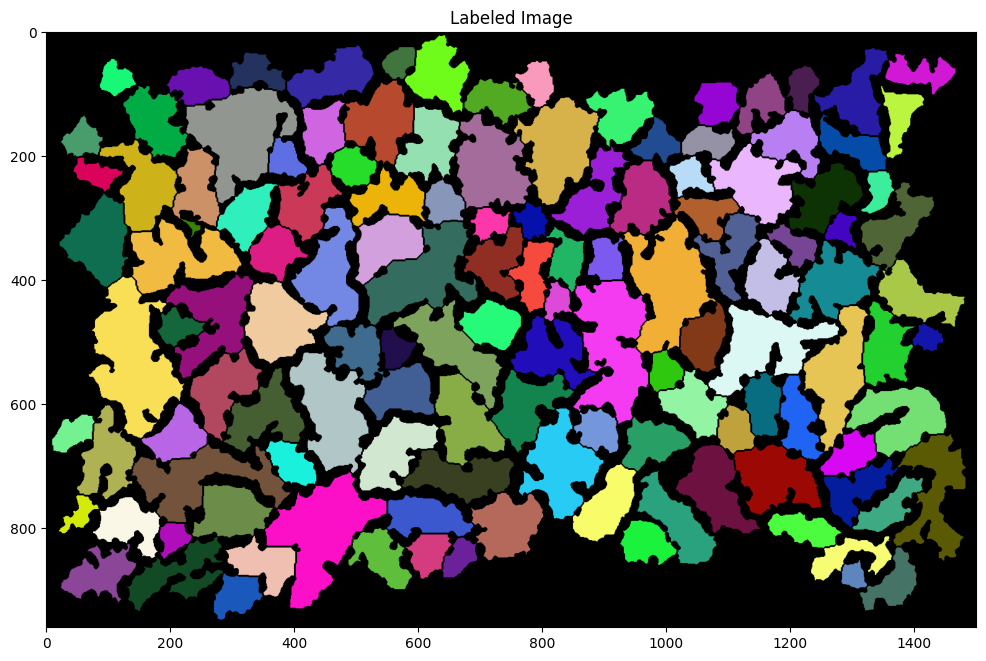

In [112]:
final_labels = segmentation.clear_border(label(grain_cleaned))
BSSEM_utils.visualize_labeled(final_labels)

Grain analysis saved to: ..\image_files\AG56-A\AG56-D2-A-50K-002_grain_analysis.csv

Grain Analysis Results:
Number of grains: 129
Average grain area: 17065.33 nm²
Average grain diameter: 140.79 nm
25th percentile: 109.56 nm
Median grain diameter: 138.90 nm
75th percentile: 164.99 nm


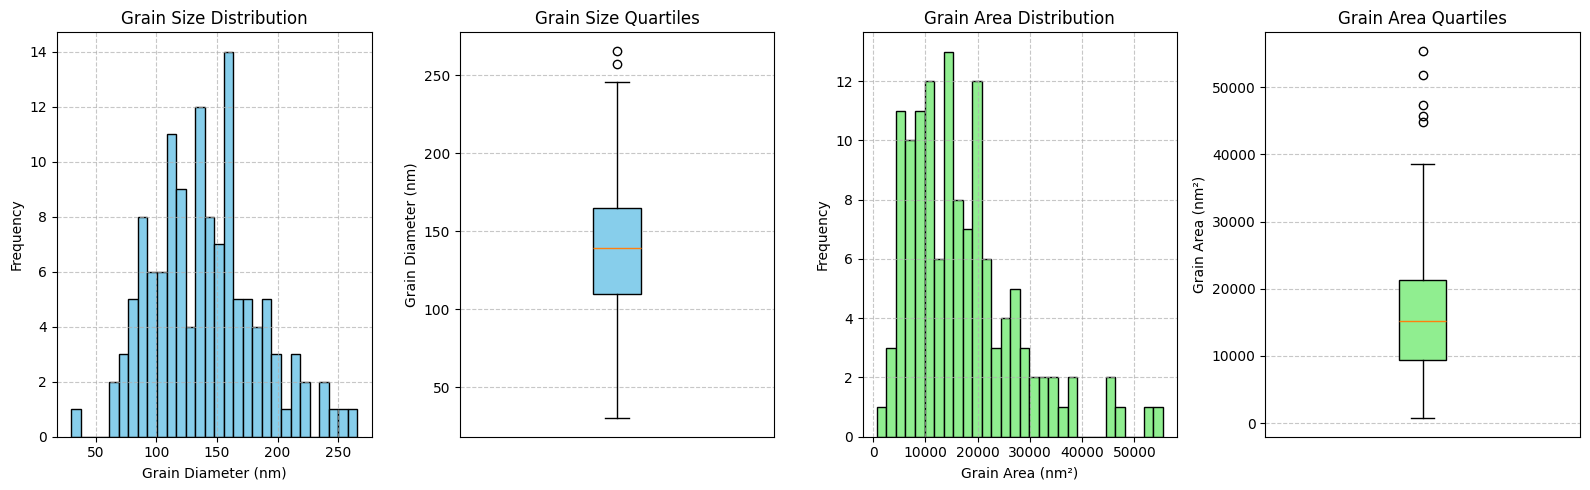

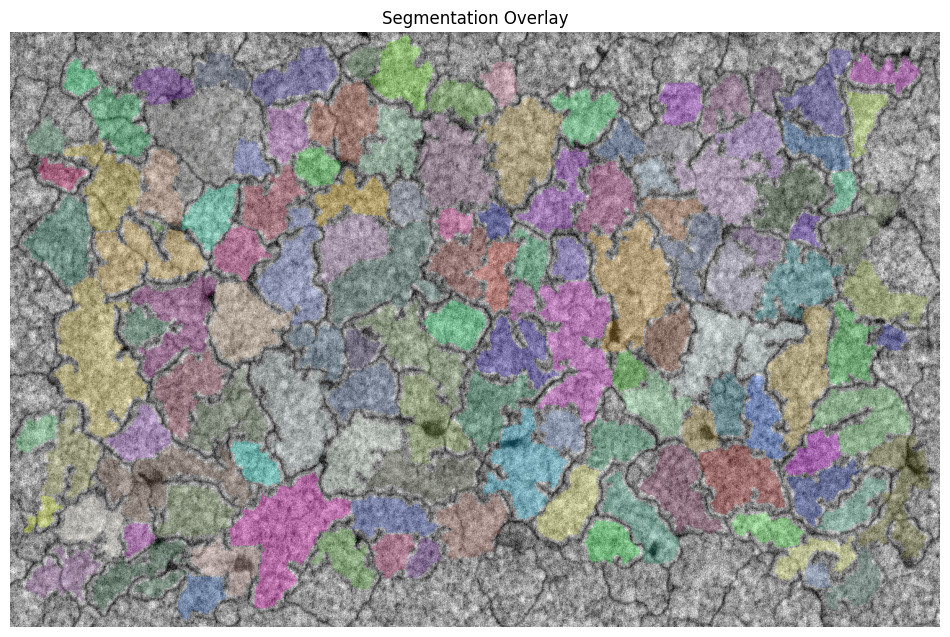

uint8


In [113]:
# analyze grains
SCALE_FACTOR = 0.603 # pixel/nm
grain_data = BSSEM_utils.analyze_grains(final_labels, scale_factor=SCALE_FACTOR)
# Include the image filename to create a descriptive output name
BSSEM_utils.save_grain_analysis(grain_data, image_filename=image_filename, save_dir=image_dir)

# Fix for aspect ratio infinity values (add this line)
aspect_ratios = grain_data['major_axis_lengths'] / np.maximum(grain_data['minor_axis_lengths'], 1e-10)
grain_data['aspect_ratios'] = np.clip(aspect_ratios, 0, 10)  # Clip to reasonable range

BSSEM_utils.visualize_grain_statistics(grain_data)

# Step 7: Create overlay on original image
segmentation_demo = BSSEM_utils.visualize_overlay(test_image, final_labels)
print(segmentation_demo.dtype)

segmentation_with_bar = BSSEM_utils.add_simple_scale_bar(segmentation_demo)


Saved prediction to: ..\image_files\AG56-A\AG56-D2-A-50K-002_seg_result.tif


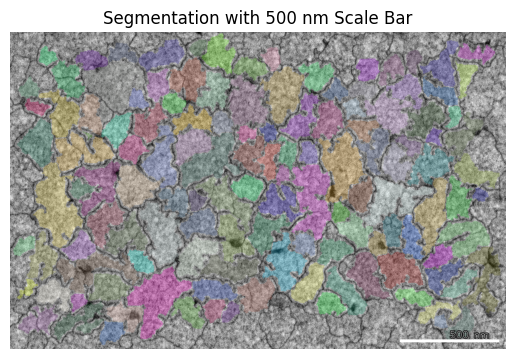

In [114]:

output_filename = image_filename + '_seg_result.tif'  # Better naming convention
output_path = os.path.join(image_dir, output_filename)
# Save the predicted labels to the output path
imsave(output_path, segmentation_with_bar) 

print(f"Saved prediction to: {output_path}")

# Show result
plt.figure()
plt.imshow(segmentation_with_bar)
plt.title('Segmentation with 500 nm Scale Bar')
plt.axis('off')
plt.show()

In [115]:
# ================= Generate PDF Report =================
# Generate a comprehensive PDF report with all grain analysis data
report_path = BSSEM_utils.generate_grain_analysis_report(
    grain_data=grain_data,
    segmentation_image=final_labels,
    original_image=test_image,
    overlay_image=segmentation_with_bar,
    image_filename=image_filename,
    save_dir=image_dir
)

print(f"PDF report generated successfully and saved to: {report_path}")

Grain analysis report saved to: ..\image_files\AG56-A\AG56-D2-A-50K-002_grain_analysis_report.pdf
PDF report generated successfully and saved to: ..\image_files\AG56-A\AG56-D2-A-50K-002_grain_analysis_report.pdf
